# Tangramm - predictive modelling using train and test samples

The input adata contains:
    42 units of training set
    941 units of testing set
    259 features in any of population units
    all of the data are supposed to be continuous values.
    
The plan of investigation:
1. Data scaling (standatization of features)
2. Filter the features - reduce the number of features to use in model fitting
3. Select the models that can be used  for prediction
4. Fitting the models with different parameters
5. Choose the best model

##### Data scaling (standatization of features)
Scale the features to transform the original sample to sample with Mean==0, and Standard deviation==1

##### Filter the features
Try to reduce the number of features and use the most significant for modelling using the mutual information assessment between features and output predicted values.

##### Select the models that can be used  for prediction
There are three different regression models that were choosen to predict the output:
Kernel Ridge Regression
Random Forest Regression
Support Vector Regression
Any of them can predict the continuous output that is necessary according to the problem statement.

##### Fitting the models with different parameters
Kernel Ridge Regression and Support Vector Regression can have different kernels - linear or nonlinear and other paramenters that can be used for fitting.
Random Forest Regression is the mix of decision trees that is used to achieve best model on the training set.

##### Choose the best model
Using the assessment of different models with different parameters we chose the best one based on train data. The prediction is built for test data. Then we calculate the assessment of achieved results using mean squarerd error(MSE), mean relative error(MRE) and analysis of error's distribution.

In [16]:
import scipy as sp
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

D=pd.read_csv("https://raw.githubusercontent.com/AnnaDS/tangramm/master/tangramm_test.csv")

D.columns=[x.strip() for x in D.columns]

print("Data split.")
Dtrain=D[D['test']==0]
Dtest=D[D['test']==1]

r=list(D.columns.difference(['test', 'class']))
#Data frame of train samples
Dtrain_x=Dtrain[r]
#Data frame of test samples
Dtest_x=Dtest[r]

scaler = StandardScaler()
y_train=Dtrain['class']
y_test=Dtest['class']
#Feature's names
features=Dtest_x.columns

#Scale of features (standartization)
scaler.fit(Dtrain_x)  # Don't cheat - fit only on training data
X_train = scaler.transform(Dtrain_x)
X_test = scaler.transform(Dtest_x)  



def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

#Fnction to find mutual information between feature and output
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi
    
comp=[x/10 for x in range(1,10)]
k=0
best=pd.DataFrame()

# Build the data with different number of fetaures  according to their 'importance' 
#(limit value of mutual information k)
#and build the different models choosing best parameters in Grid search
for k in comp:
    scores=[]
    for i in range(0,len(features)):
        s = calc_MI(list(zip(*X_train))[i], list(y_train), 10)
        scores.append(s)
    
    mii=find_indices(np.array(scores), lambda e: e > k)
    if len(mii)<2 :
        break
    X_train_mi=X_train[:,mii]
    X_test_mi=X_test[:,mii]
    features_mi=features[mii]
    
    print("CV starts.")    
    #Support vector regression
    svr = svm.SVR()   
    param_grid = [{'alpha' : 10.0**-np.arange(1,7),'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]}]
    parameters_svr = {'kernel':('linear', 'rbf'), 'C':list(range(1, 100))}
    gs_svr = GridSearchCV(svr,parameters_svr,n_jobs=8,verbose=1)
    gs_svr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'SVR', 'k':k,'estimator':gs_svr.best_estimator_, 'score': gs_svr.best_score_, 'params':gs_svr.best_params_}), ignore_index=True)

    #Kernel Ridge regression
    kr=KernelRidge()
    parameters_kr = { 'gamma': [0.01, 0.001, 0.0001], 'kernel': ('linear', 'rbf')}
    gs_kr = GridSearchCV(kr,parameters_kr,n_jobs=8,verbose=1)
    gs_kr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'KernelRidge', 'k':k,'estimator':gs_kr.best_estimator_, 'score': gs_kr.best_score_, 'params':gs_kr.best_params_}), ignore_index=True)

    #Random Forest regression
    rfr=RandomForestRegressor()
    parameters_rfr = {'n_estimators': [500, 700, 1000, 10000], 'max_depth': [None, 1, 2, 3, 4, 5,6], 'min_samples_split': [1, 2, 3]}
    gs_rfr = GridSearchCV(rfr,parameters_rfr,n_jobs=8,verbose=1)
    gs_rfr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'RandomForest', 'k':k,'estimator':gs_rfr.best_estimator_, 'score': gs_rfr.best_score_, 'params':gs_rfr.best_params_}), ignore_index=True)


#Select best options fom model selections according to the results using list of models and parameters

V=best.score.tolist().index(max(best.score))
BV=best.ix[[V]]
mii=find_indices(np.array(scores), lambda e: e > float(BV.k))

X_train_mi=X_train[:,mii]
X_test_mi=X_test[:,mii]
features_mi=features[mii]
s = BV.estimator.tolist()[0]#svm.SVR(C=99, kernel='linear')
s.fit(X_train_mi, y_train)
    
print("Selected model with params:")
print(str(BV.estimator.tolist()[0]))
print("Best score on the train data:")
print(s.score(X_train_mi, y_train))
print("Best score on test data:")
print(s.score(X_test_mi, y_test.values))
print("MSE of prediction:")
print(np.average(abs(s.predict(X_test_mi)-y_test.values)**2))
print("Average relative accuracy:")
print(100-np.average(abs((s.predict(X_test_mi)-y_test.values)/y_test.values)))

Data split.
CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.6s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   49.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.6min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   43.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.2min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 18.7min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed: 27.6min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.1min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.7min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.9min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    1.2s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.7min finished


Selected model with params:
SVR(C=99, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score on the train data:
0.372405550961
Best score on test data:
-0.191549807322
MSE of prediction:
237771216.606
Average relative accuracy:
99.5629415324


In [92]:
D['prediction']=s.predict(X_train_mi).tolist()+s.predict(X_test_mi).tolist()
D.to_csv('tangramm_results.csv')

#### Plot the score of fitted model depends on number of mutual information between features and output for different models

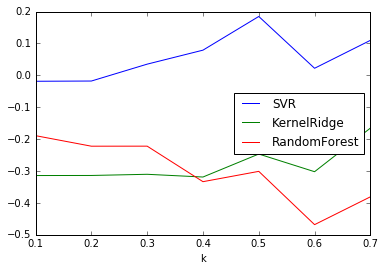

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 
result = pd.merge(best[best.model=='SVR'][['k','score']], best[best.model=='KernelRidge'][['k','score']], on='k')
result = pd.merge(result, best[best.model=='RandomForest'][['k','score']], on='k')
result=result.set_index(result.k)
result.columns=['k','SVR', 'KernelRidge', 'RandomForest']
result=result[['SVR', 'KernelRidge', 'RandomForest']]
result.plot()

#### Histograms of errors

(array([ 382.,  316.,  193.,   53.,   15.,    8.,    8.,    2.,    0.,    6.]),
 array([  4.48673263e-04,   2.70715306e+01,   5.41426125e+01,
          8.12136945e+01,   1.08284776e+02,   1.35355858e+02,
          1.62426940e+02,   1.89498022e+02,   2.16569104e+02,
          2.43640186e+02,   2.70711268e+02]),
 <a list of 10 Patch objects>)

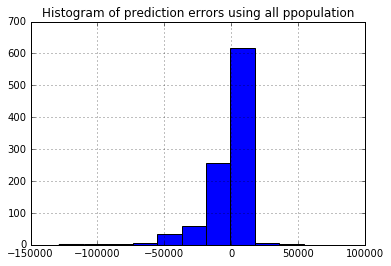

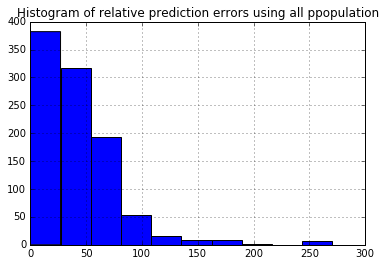

In [64]:
D_res=D
D_res['prediction']=np.concatenate([y_train_pred, y_test_pred])
D_res['error']=D_res['prediction']-D_res['class']
D_res['relative_error']=100*abs(D_res['error']/D_res['class'])
plt.hist(D_res['error'])
plt.title('Histogram of prediction errors using all ppopulation')
plt.grid(True)
plt.figure()
plt.title('Histogram of relative prediction errors using all ppopulation')
plt.grid(True)
plt.hist(D_res['relative_error'])

# Feature's clustering
In order to improve the prediction results we'll try aggregate features and reduce the dimension. According to the curse of dimensionality phenomena ( https://en.wikipedia.org/wiki/Curse_of_dimensionality) the predictive power reduces when the number of features is too big (bigger than samples number), thus we'll try to reduce the dimension using feature's wrapping based on clustering and Principal component analysis.

In [74]:
import numpy as np
import scipy as sp
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def get_clustered(X_test, labels_):
    df=pd.DataFrame()
    for l in set(labels_):
        r= np.rot90(X_test)[np.where(labels_==l)].mean(0)
        df[l]=r
    return np.array(df)
    #np.rot90(SN)[np.where(labels_==0)].mean(0)
    
    
for i in range(10,20):
    print('N clusters ', i)
    kmeans = KMeans(init='k-means++',   n_clusters=i, n_init=100)
    kmeans.fit(np.rot90(X_train))
    labels_=kmeans.labels_
    centers=kmeans.cluster_centers_
    XT=get_clustered(X_train, labels_)
    s = svm.SVR()
    s1=s.fit(XT, y_train)
    print(s1.score(XT, y_train))
    XX=get_clustered(X_test, labels_)
    print(s1.score((XX), y_test))
    print("Average error")
    print(np.average(100*abs((s1.predict(XX)-y_test.values)/y_test.values)))


N clusters  10
-0.0876950620773
-0.188739918789
Average error
28.486121756
N clusters  11
-0.0876958262413
-0.188720645397
Average error
28.4865351718
N clusters  12
-0.0876898005095
-0.188686148989
Average error
28.485477352
N clusters  13
-0.0877009194674
-0.188758377287
Average error
28.4856560071
N clusters  14
-0.0877210283758
-0.188782486679
Average error
28.4858257232
N clusters  15
-0.087609916528
-0.188678638713
Average error
28.4863558485
N clusters  16
-0.0876759667218
-0.188748569942
Average error
28.4858970167
N clusters  17
-0.0876380655913
-0.18870533042
Average error
28.4865630193
N clusters  18
-0.0876502966628
-0.188767386385
Average error
28.4855609052
N clusters  19
-0.0876502273157
-0.188748060327
Average error
28.4867720178


[<matplotlib.text.Text at 0x1180eec18>, <matplotlib.text.Text at 0x1180ca438>]

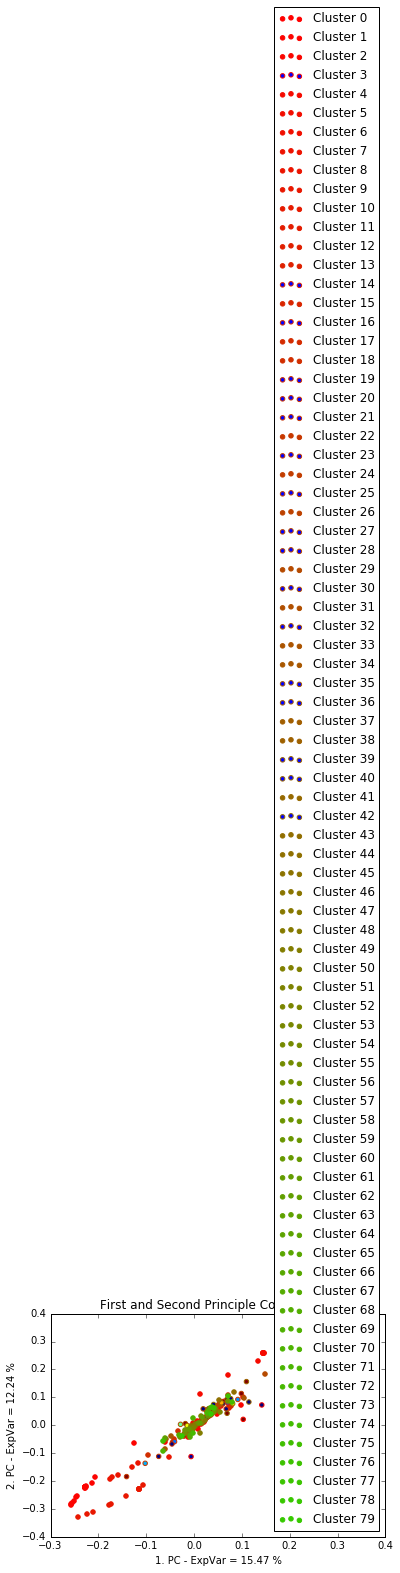

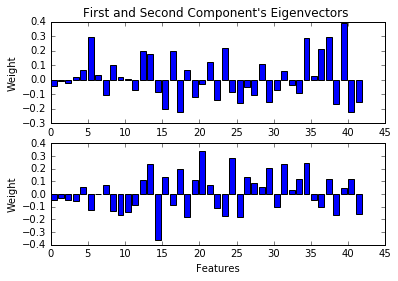

In [71]:
"""
Created on Wed Dec  2 16:16:06 2015

@author: annachystiakova
"""

def dim_red_pca(X, d=0, corr=False):
    # Center to average
    X_ = X-X.mean(0)
    # Compute correlation / covarianz matrix
    if corr:
        CO = np.corrcoef(X_.T)
    else:
        CO = np.cov(X_.T)
    # Compute eigenvalues and eigenvectors
    e_values, e_vectors = sp.linalg.eigh(CO)

    # Sort the eigenvalues and the eigenvectors descending
    idx = np.argsort(e_values)[::-1]
    e_vectors = e_vectors[:, idx]
    e_values = e_values[idx]
    # Get the number of desired dimensions
    d_e_vecs = e_vectors
    if d > 0:
        d_e_vecs = e_vectors[:, :d]
    else:
        d = None
    # Map principal components to original data
    LIN = np.dot(d_e_vecs, np.dot(d_e_vecs.T, X_.T)).T
    return LIN[:, :d], e_values, e_vectors
    
import numpy as np
import scipy as sp
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SN = X_train
kmeans = KMeans(init='k-means++',  n_clusters=80, n_init=100)
kmeans.fit(np.rot90(SN))
s1=s.fit(np.rot90(kmeans.cluster_centers_), y_train)
labels_=kmeans.labels_
clust=kmeans.cluster_centers_
#clust,labels_ = kmeans2(SN,3)    # cluster with 3 random initial clusters
# PCA on orig. dataset 
# Xred will have only 2 columns, the first two princ. comps.
# evals has shape (4,) and evecs (4,4). We need all eigenvalues 
# to determine the portion of variance
Xred, evals, evecs = dim_red_pca(np.rot90(SN),2)   

xlab = '1. PC - ExpVar = {:.2f} %'.format(evals[0]/sum(evals)*100) # determine variance portion
ylab = '2. PC - ExpVar = {:.2f} %'.format(evals[1]/sum(evals)*100)
# plot the clusters, each set separately


import colorsys
def pseudocolor(val, minval, maxval):
    # convert val in range minval...maxval to range 0..1
    f = float(val-minval) / (maxval-minval)
    # linearly interpolate that value between the colors red and green
    r, g, b = 1-f, f, 0.
    return r, g, b
clr=list()
steps = round(100/kmeans.n_clusters)

for val in range(0, 100, steps):
    #print ('%3d -> (%.3f, %.3f, %.3f)' % ((val,) + pseudocolor(val, 0, 100)))
    clr.append(pseudocolor(val, 0, 100))

plt.figure()    
ax = plt.gca()
scatterHs = []

for cluster in set(labels_):
    scatterHs.append(ax.scatter(Xred[np.where(labels_.tolist() == cluster), 0], Xred[np.where(labels_.tolist() == cluster), 1], 
                   color=clr[cluster], 
                    label='Cluster {}'.format(cluster)))
plt.legend(handles=scatterHs,loc=4)
plt.setp(ax, title='First and Second Principle Components', xlabel=xlab, ylabel=ylab)
fig, ax = plt.subplots(2,1)
ax[0].bar(range(42),evecs[0])
plt.setp(ax[0], title="First and Second Component's Eigenvectors ", ylabel='Weight')
ax[1].bar(range(42),evecs[1])
plt.setp(ax[1], xlabel='Features', ylabel='Weight')

In [72]:
s1.score(np.rot90(kmeans.cluster_centers_), y_train)

0.45383539944911422

In [73]:
kmeans2 = KMeans(init='k-means++',  n_clusters=80, n_init=100)
kmeans2.fit(np.rot90(X_test))
s1.score(np.rot90(kmeans2.cluster_centers_), y_test)

-3.4351058229066084e+39